# Kernel machines

When we're doing statistics with objects, it's not always the case that they can be encoded as a fixed-sized vector (typically $\boldsymbol{x}\in \mathbb{R}^D$). For example, a text document, protein sequence, or molecular structure are all examples of objects in the world we may wish to perform inference on, but do not conform to fixed-sized vectors.

One way to make progress is if we are able to define a metric of similarity between objects that doesn't require reprocessing the object into a fixed-sized vector. We call such an object a **kernel function**, satisfying $\kappa(\boldsymbol{x},\boldsymbol{x}')\geq 0$, where $\boldsymbol{x},\boldsymbol{x}'$ are elements of some abstract space $\mathcal{X}$.

In this demo, we describe **kernel machines**, which are [generalised linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) where the input feature vector has the form

$$\boldsymbol{\phi}(\boldsymbol{x}) = [\kappa(\boldsymbol{x},\boldsymbol{\mu}_1), \dots, \kappa(\boldsymbol{x},\boldsymbol{\mu}_K)]$$

where $\boldsymbol{\mu}_k \in \mathcal{X}$ are a set of $K$ centroids. Here, for simplicity, we choose

$$\kappa(\boldsymbol{x},\boldsymbol{x}') = \exp\left(-\frac{||\boldsymbol{x}-\boldsymbol{x}'||^2}{2\sigma^2}\right)$$

where $\boldsymbol{x}\in \mathbb{R}^D$, and $\boldsymbol{\mu}_k$ and $\sigma$ are assumed to be given (although there are sensible ways to choose these in general). $\kappa$ is called a **radial basis function** (RBF), and $\boldsymbol{\phi}(\boldsymbol{x})$ a **kernelised feature vector**, and the model an **RBF network**. 

We will use the kernelised feature vector to do logistic regression by defining

$$p(y|\boldsymbol{x},\boldsymbol{\theta}) = \text{Ber}(\text{sigm}(\boldsymbol{w}^T\boldsymbol{\phi}(\boldsymbol{x})))$$ where $\text{Ber}()$ is the probability mass function of the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) and $\text{sigm}(z) = 1/(1+e^{-z})$ is a sigmoid function. This model offers us an easy way to generate non-linear decision boundaries.

Based on Ch14 of Machine Learning: A Probabilistic Perspective

Author: Juvid Aryaman

In [1]:
import numpy as np
import utls
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
utls.reset_plots()

## Generate data

Make data from an XOR table

|$x_1$ | $x_2$|$y$|
|---|---|---|
|0 | 0|0|
|0 | 1|1|
|1 | 0|1|
|1 | 1|0|

then scale $x_i$ and add some noise. We wish to classify the feature vector $\boldsymbol{x} \in \mathbb{R}^2$ according to $y=\text{XOR}(x_1,x_2)$. Note that even a 10th order polynomial struggles with this task (see Figure 14.2 of Murphy).


In [3]:
n = 150
x1 = np.random.binomial(1,p=0.5,size=n)
x2 = np.random.binomial(1,p=0.5,size=n)
y = x1 != x2 # XOR
y_vals_all = y.astype(int)
x1 = 5*(x1 + np.random.uniform(-0.3,0.3,size=n))
x2 = 5*(x2 + np.random.uniform(-0.3,0.3,size=n))
X = np.vstack((x1,x2)).transpose()

# Train/test partition
n_train = 100
X_train = X[:n_train]
y_vals_train = y_vals_all[:n_train]

X_test = X[n_train:]
y_vals_test = y_vals_all[n_train:]

Text(0, 0.5, '$x_2$')

/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


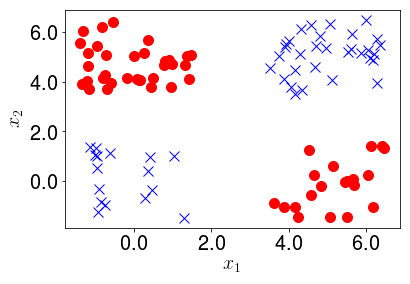

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(X_train[y[:n_train],0],X_train[y[:n_train],1],'ro')
ax.plot(X_train[~y[:n_train],0],X_train[~y[:n_train],1],'bx')
utls.remove_tex_axis(ax,xtick_fmt="%.1f",ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

## RBF Network kernel machine

Use an RBF network kernel machine to make a simple non-linear classifier

In [5]:
def RBF_kernel(x1,x2,sigma):
    """
    Radial basis function kernel
    
    Params
    -------
    x1 : A numpy array of length D
    x2 : A numpy array of length D
    sigma : A double, the bandwidth of the kernel
    
    Returns
    ---------
    RBF(x1,x2)
    """
    return np.exp(-np.dot((x1-x2),(x1-x2))/(2*sigma*sigma))

Assume the centroids $\boldsymbol{\mu}_k$ are known, as well as $\sigma$

In [6]:
mu = np.array([[0,0],[0,5],[5,0],[5,5]]) # define 4 centroids. These are parameters of the model

Make the kernelised feature vector

In [7]:
sigma = 1.0
phi_train = []
for i in range(4):
    phi_train.append([RBF_kernel(xi, mu[i], sigma) for xi in X_train])
phi_train = np.array(phi_train).transpose() # kernelised feature vector
phi_train.mean(), phi_train.std(ddof=1), phi_train.min(), phi_train.max()

(0.12803097565373578,
 0.24859775218248475,
 1.1068117536390567e-17,
 0.9995580496118893)

In [8]:
phi_train.shape

(100, 4)

Perform logistic regression on the kernelised feature vector

In [9]:
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr').fit(phi_train, y_vals_train)

Test the model with `X_test`

In [10]:
phi_test = []
for i in range(4):
    phi_test.append([RBF_kernel(xi, mu[i], sigma) for xi in X_test])
phi_test = np.array(phi_test).transpose() # kernelised feature vector
phi_test.shape

(50, 4)

In [11]:
y_pred = clf.predict(phi_test)
y_pred.shape

(50,)

In [12]:
y_pred = y_pred.astype(bool)

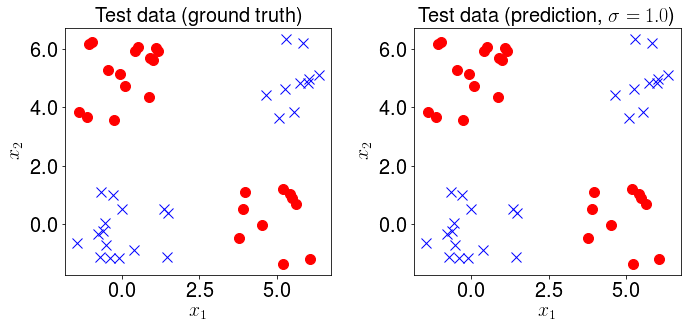

In [13]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))
axs = axs.ravel()

ax = axs[0]
ax.plot(X_test[y[n_train:],0],X_test[y[n_train:],1],'ro')
ax.plot(X_test[~y[n_train:],0],X_test[~y[n_train:],1],'bx')
utls.remove_tex_axis(ax,xtick_fmt="%.1f",ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Test data (ground truth)')

ax = axs[1]
ax.plot(X_test[y_pred,0],X_test[y_pred,1],'ro')
ax.plot(X_test[~y_pred,0],X_test[~y_pred,1],'bx')
utls.remove_tex_axis(ax,xtick_fmt="%.1f",ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Test data (prediction, $\sigma = {}$)'.format(sigma))

plt.tight_layout()